# Optimización numérica y su aplicación en Machine Learning

### Alcances de la lectura
> * Conocer el problema de la optimización y su terminología.
>
> * Reconocer las principales variantes del método de Gradiente Descendente (Normal, Batch, Mini, Stochastic).
>
> * Implementar y analizar sus ventajas con `sklearn`.

Hasta el momento, el curso ha sido una exposición exhaustiva a distintos tipos de algoritmo y cómo éstos resuelven los problemas canónicos de regresión y clasificación. Sin embargo, hemos omitido un aspecto esencial sobre el aprendizaje estadístico: _¿Cómo las máqunas son capaces de aprender los parámetros de un modelo?_ Este tema resulta ser vital para comprender cómo funciona una red neuronal. Dependiendo de cómo construyamos una, su desempeño puede variar de manera substancial dependiendo del método de optimización que implementemos.

En esta sección estudiaremos los principales mecanismos de optimización que se utilizan para entrenar redes neuronales.

## ¿Qué es y por qué necesitamos algoritmos de optimización?

Como lo indica su nombre, un algoritmo de optimización permite encontrar o aproximarnos al óptimo de una función objetivo de un algoritmo. 

Un algoritmo de minimización permite encontrar o aproximar el óptimo de una función, llamada por lo general función objetivo del algoritmo. El _'óptimo'_ de la función objetivo depende de lo que estemos haciendo, si estamos minimizando una función de pérdida o costo el óptimo que buscará el algoritmo serán los parámetros del modelo que hacen que esa función de costo tome el menor valor posible, de forma análoga para cuando queremos máximizar una función de ganancia (por ejemplo la verosimilitud).

Existen distintas formas para encontrar el óptimo de una función, comenzaremos con el más intuitivo y en el que se basan la mayoría de los algoritmos de optimización actuales:

# Métodos basados en gradiente

## Gradiente Descendente clásico (_Gradient Descent_)

Imaginemos que estamos en un parque el cual tiene un terreno bastante irregular, con colinas y llanos. Nosotros estamos parados en un punto cualquiera y nuestro objetivo es llegar al punto más bajo del parque (vamos a minimizar), pero hay un pequeño detalle, tenemos los ojos vendados, por lo que no podemos ver hacia adonde nos conviene movernos, lo único que podemos hacer es sentir la inclinación del terreno bajo nuestros pies. 

Una aproximación lógica a este problema es irnos siempre por la dirección de mayor descenso desde el punto en el que estamos parados, la aproximación que utilizan los métodos basados en gradiente es la misma: Calculan, en un cierto punto, el __gradiente__ de la función objetivo en ese punto y eligen la dirección que tiene _"mayor inclinación"_.

Consideremos el clásico problema de ajustar una regresión lineal a un conjunto de datos.
Recordando la primera unidad del curso, nuestro modelo tiene la siguiente forma:

$$
\hat{y}(\gamma, \beta) = \gamma + \beta\cdot x
$$
Donde:
* $\gamma$ es el intercepto.
* $\beta$ es la pendiente.

Los parámetros de este modelo (y que definen la curva) son el intercepto $\gamma$y la pendiente $\beta$. Si trabajamos bajo la asumnción de que los datos en efecto siguen un comportamiento lineal, nuestro problema es entonces encontrar los parámetros análogos a $\gamma$ y $\beta$ que hacen que la curva se ajuste a los datos. Para simplificar el ejemplo asumiremos que los datos están centrados en $0$ y nuestro problema solo está en encontrar el valor correcto de $\beta$.

Ahora debemos definir una función de costo, es decir, el _cómo_ vamos a penalizar al modelo cuando proponga una combianción de parámetros que no se ajuste a los datos. Utilizaremos la suma de los cuadrados de la regresión como __función de costo__:

$$
\textsf{RSS} = J(\beta) = \sum_{i = 0}^{N} (y_{i} - \hat{y}(\beta)_{i})^2
$$

El algoritmo de gradiente descendente lo que hará es una actualización iterativa del parámetro que estamos tratando de estimar ($\beta$), de forma de ir encontrando cada vez valores que minimicen de mejor forma la función de costo del modelo. En cada iteración $j$, el modelo evaluará la función de costo en el parámetro actual estimado y analizará, basándose en la gradiente de la función de costo, hacia que valores del parámetro la función de costo parece decrecer más. 

Formalmente, si $\theta$ son los parámetros del modelo que estemos entrenando y $E[J(\theta)]$ el valor esperado de la función de costo elegida evaluada en los parámetros actuales, la actualización de parámetros que implementa gradiente descendente es de la siguiente manera:

$$
\hat{\theta}_{i} \leftarrow \hat{\theta}_{i} - \alpha \nabla_{\theta} \mathbb{E}[J(\theta)]
$$

El coeficiente del gradiente ($\alpha$) se llama **_learning rate_** (tasa de aprendizaje, abreviado también como $lr$) y es un aspecto clave de este método, pues dicta _qué tanto_ va a cambiar el parámetro en cada iteración. Un learning rate alto provoca que el método se mueva a saltos grandes en el espacio de búsqueda, por otro lado, un learning rate bajo provoca que este avance a saltos pequeños. (__COMENTARIO: IMPLEMENTAR GRÁFICO DE GERON PAGINA 116)

### Efecto del learning rate

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from opti_graphs import *
import matplotlib.pyplot as plt
from ipywidgets import interactive
import numpy as np
plt.style.use('ggplot')

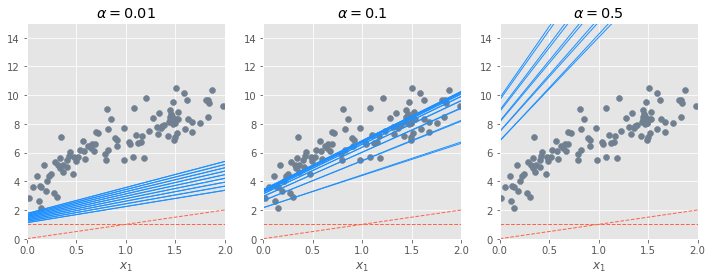

In [13]:
# Generamos un conjunto de datos artificial
X, y = artificial_points()

plt.figure(figsize=(10, 4))
# compararemos el efecto del descenso de gradiente batch en tres niveles
for i, n in enumerate([0.01,0.1, 0.5]):
    plt.subplot(1, 3, i + 1)
    batch_gd_plot(X, y, theta=1, alpha=n)
    plt.tight_layout()

En la simulación generada, evaluamos el comportamiento del algoritmo en función a la tasa de aprendizaje. Cuando es muy bajo ($\alpha=0.01$) el algoritmo podrá alcanzar la solución eventualmente, pero se demorará. Cuando el valor es relativamente alto ($\alpha=0.5$), el algoritmo diverge respecto a los datos y su comportamiento se torna errático, fallando en la solución. Al implementar un valor mediano, en este caso el algoritmo alcanza una representación más cierta de los datos por cada iteración

### Dificultades de GD clásico
* El _learning rate_ es un hiperparámetro, lo que significa que probablemente nuestra mejor apuesta a encontrar valores óptimos de este sea mediante heurísticas (e.g. La intuición nos dice que quizás no sea conveniente usar un $lr = 10^{20}$...).
* Aún cuando encontremos un valor razonable para el learning rate, la superficie del espacio de búsqueda puede tener una topología complicada, haciendo que nuestro $lr$ se desempeñe bien en ciertos lugares y pésimo en otros. Este problema está asociado con la posibilidad de encontrar óptimos locales.
* Una característica especialmente complicada de los espacios de búsqueda son las llamadas _plateau_, las cuales representan valles, rodeados por máximos o mínimos locales, para un algoritmo basado en gradiente este tipo de geografías son mortales, pues no le dan información de hacia adonde ir en ningún punto.
* Aplicar el mismo learning rate a todos los atributos es poco flexible, lo ideal sería que el optimizador pudiese elegir cuanta importancia darle a los movimientos realizados en cada atributo para buscar la solución.
* En su forma clásica, gradiente descendente utiliza todo el conjunto de entrenamiento para efectuar una sola actulización de los parámetros del modelo, lo que lo hace poco eficiente cuando se quiere trabajar con las cantidades de datos que manejamos usualmente.



>#### Digresión: Optimización Convexa
> Los algoritmos de descenso de gradiente forman parte del estudio de la __optimización convexa__. Todo espacio o superficie de un problema que tenga forma de pozo se conoce como un espacio convexo. El objetivo es encontrar un mínimo/máximo en toda la superficie de la función. Partamos por un ejemplo donde existe un mínimo __global__, generado con la función `global_surface`.

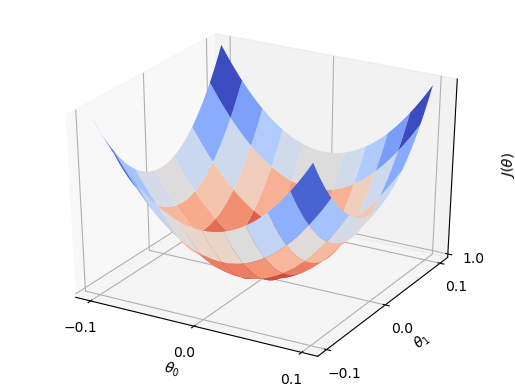

In [14]:
plt.style.use('default'); global_surface()

> En esta situación, existe un punto mínimo donde los valores de $\theta_{0}$ y $\theta_{1}$ minimizan la función objetivo ($J(\theta)$). Ésta zona está caracterizada con un color rojo. En este ejemplo, nuestro algoritmo considerará los valores de $\theta_{0}$ y $\theta_{1}$ cuando estén cercanos a cero, dado que es en ésta combinación de parámetros donde se encuentra el óptimo.
>
> Lamentablemente ésta es una situación ideal que no se encuentra mucho en el mundo real. Por lo general las funciones objetivo tienen superficies mucho más complejas, relacionadas con la dimensionalidad del problema. Una visualización más real se ofrece con la figura generada con `max_min_surface()`

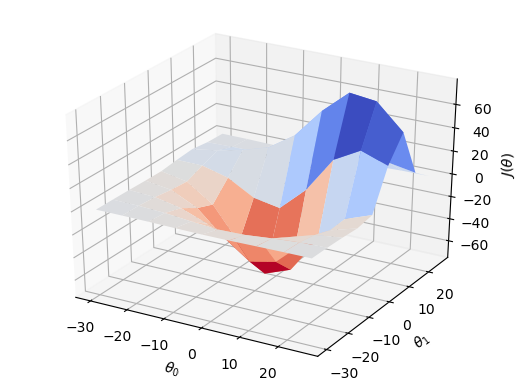

In [15]:
plt.style.use('default'); max_min_surface()

> En esta situación la búsqueda de parámetros en la superficie irregular dependerá en parte por el punto de inicio del algoritmo. Puede existir situaciones donde el algoritmo se puede quedar estancado en mínimos locales, lejos de la minimización global de la superficie de la función. Otro ejemplo de éste comportamiento se ofrece con la figura `saddle_surface()`
>

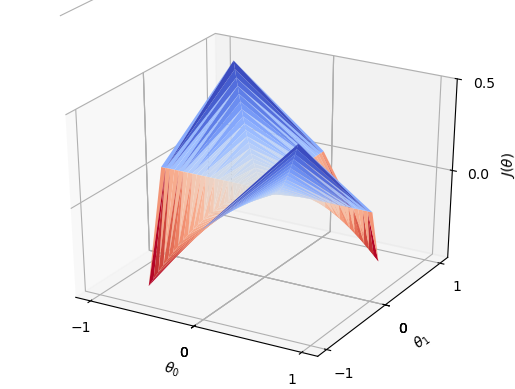

In [16]:
plt.style.use('default'); saddle_surface()

> Uno de los principales problemas que se enfrenta la Inteligencia Artificial es encontrar nuevas formas de optimizar en superficies complejas. 

## Gradiente Descendente Estocástico (SGD)

Es el método por defecto para aprender los parámetros de la mayoría de los modelos de machine learning, a diferencia de GD, SGD no utiliza todo el conjunto de entrenamiento para hacer una actualización de los parámetros, en lugar de eso, __actualiza los parámetros una vez por cada elemento del conjunto de entrenamiento__.

$$
\hat{\theta}_{i}^{j} \leftarrow \hat{\theta}_{i}^{j-1} - \alpha \nabla_{\theta} J(\theta; x^{(i)};y^{(i)})
$$

Como SGD tiene una tasa de actualización mucho más alta que GD, suele ser más eficiente para encontrar mínimos/máximos, el problema es que esa misma tasa alta de actualización de parámetros hace que el método tenga una alta varianza en cuanto a performance.

Veamos como se comporta gráficamente SGD:

In [17]:
interactive(gradient_1d, alpha = (1,6))

interactive(children=(IntSlider(value=1, description='alpha', max=6, min=1), Output()), _dom_classes=('widget-…

En el widget anterior se muestran las distintas curvas que ajusta el modelo en cada iteración, partiendo de un coeficiente $\beta_{0} = 0.000$ ajusta el valor del $\beta$ cada vez más, provocando que la curva se ajuste mejor en cada iteración. En el gráfico de la derecha se muestran los valores de la función de costo para el valor del parámetro en cada iteración.

Podemos jugar con el valor de $\alpha$ para ver como varía la forma en la que se recorre el espacio de búsqueda, un learning rate alto hace que los saltos en los costos de la función de costo sean más bruscos.

Como referencia, el valor fijado para el parámetro es de 0.5, por lo tanto el modelo debiese buscar valores lo mas cercanos posibles a este valor. Si fijamos un $\alpha = 3$ vemos una clara convergencia a este valor de forma casi inmediata, sin embargo, si fijamos un $\alpha$ demasiado pequeño o demasiado caemos en sub-óptimos.

Veamos ahora como se comporta el mismo problema pero ahora considerando el intercepto como parte de los parámetros de búsqueda:

In [21]:
interactive(gradient_2d, alpha = (0.10,9))

interactive(children=(FloatSlider(value=1.0, description='alpha', max=9.0, min=0.1), Output()), _dom_classes=(…

Al introducir una segunda dimensión al problema el espacio de búsqueda crece enormemente, pasó de ser una curva a ser un plano. De forma análoga si tuviesemos que ajustar un modelo con tres parámetros o más parámetros tendríamos que estar buscando en un hiperespacio. El tamaño del espacio de búsqueda en modelos complejos se conviterte en algo imposible de explorar por completo, es por esta razón que es importante utilizar un método de minimización que permita recorrer este espacio de forma inteligente.

### Overshooting:
Es un fenómeno que ocurre al alegir un learning rate demasiado alto para las características del espacio de búsqueda. Si en el widget aumentamos el valor de $\alpha$ al máximo veremos que las curvas logradas son bastante inexactas y que el recorrido del espacio de búsqueda son saltos de un lado hacia otro sin poder llegar al centro, básicamente el learning rate es tan alto que el optimizador no puede acertar al mínimo, aunque sabe hacia adonde está.

Antes de seguir, experimente con el valor del _learning rate_ y observe el comportamiento del optimizador bajo distintos valores. ¿Qué pasa cuando elegimos un $lr$ demasiado bajo o uno demasiado alto?. 


## Batch Training

En este caso se calcula el error para cada ejemplo, pero __solo actualiza los parámetros luego de que todos los ejemplos de entrenamiento han sido evaluados__. En el caso de gradiente descendente, esto es el calculo del gradiente para todos los ejemplos antes de actualizar los parámetros.

$$
\hat{\theta} \leftarrow \hat{\theta} - \alpha \nabla_{\theta} J(\theta)
$$

_"Batch"_ se refiere conceptualmente a un _"trozo"_, por lo que Batch training trabaja con un "_trozo_" de los datos igual al conjunto de datos completo.

Una de las principales ventajas del batch training es que tiene un estimador insesgado de los gradientes, mientras mayor sea el número de ejemplos, menor será el error estándar.

## Mini-batch training
Gradiente descendente y batch training requieren que se vea por completo el conjunto de datos antes de actualizar los pesos, mientras que gradiente descendente lo hace luego de cada ejemplo de entrenamiento. Una alternativa intermedia a ambos extremos es utilizar una cantidad de ejemplos de entrenamiento mayor que un ejemplo individual y menor que el total, siguiendo la analogía de "batch" como un trozo, mini-batches se refiere a dividir el dataset de entrenamiento en trozos pequeños o particiones (Al tamaño de cada partición se le llama _"batch size"_), de forma que podamos actualizar los parámetros con más información que solo un ejemplo, es decir, la regla de actualización será:

$$
\theta \leftarrow \theta - \alpha \nabla_{\theta}J(x^{j:j+b}, y^{j:j+b})
$$

Hay que notar que es importante que el particionamiento no sea hecho con una máscara estática, es decir, los elementos que componen una partición deben ser elegidos aleatoriamente del conjunto de entrenamiento y las particiones deben ser disjuntas.

Veamos como se comporta la actualización de uno de los parámetros en cada iteración de SGD:

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.make_classification(n_samples = 500)
X_train, X_test, y_train, y_test = train_test_split(X,y)

Por ahora no es necesario prestar mucha atención al código de esta implementación, ya veremos como conformar redes neuronales más adelante, lo importante es fijarse en los gráficos de los valores que toma __uno de los pesos a lo largo de todo el entrenamiento__ con distintos valores del batch_size:

In [10]:
from keras.callbacks import ModelCheckpoint
from keras import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import LambdaCallback
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')
sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0, nesterov=False)

"""
model = Sequential()
model.add(Dense(20, input_dim=20, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd)
weights = []
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[0].get_weights()))

checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=False)
model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[print_weights])
"""

"\nmodel = Sequential()\nmodel.add(Dense(20, input_dim=20, kernel_initializer='uniform'))\nmodel.add(Activation('softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer=sgd)\nweights = []\nprint_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[0].get_weights()))\n\ncheckpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=False)\nmodel.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[print_weights])\n"

In [11]:
# Como se puede apreciar keras hace bastante complicado rescatar los pesos de una sola capa a lo largo
# de todo el entrenamiento....

model = Sequential()
model.add(Dense(20, input_dim=20, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd)
weights = []
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[0].get_weights()))

checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=False)
model.fit(X_train, y_train, batch_size=X_train.shape[0], 
          epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[print_weights])
w_all_data = [item[0] for item in [item[0] for item in [item[0] for item in weights]]]


ax.plot(np.linspace(1,100,100),w_all_data)
plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Valor del parámetro del modelo')
plt.title('batch_size = Todo el conjunto de entrenamiento (Batch mode)', size = 15);

TypeError: softmax() got an unexpected keyword argument 'axis'

Al entrenar con un batch size igual al tamaño del conjunto de entrenamiento podemos ver como el parámetro disminuye casi como una linea recta hacia un valor, sin embargo, a pesar de haberlo entrenado con 100 ciclos de entrenamiento no parece converger a algún valor específico.

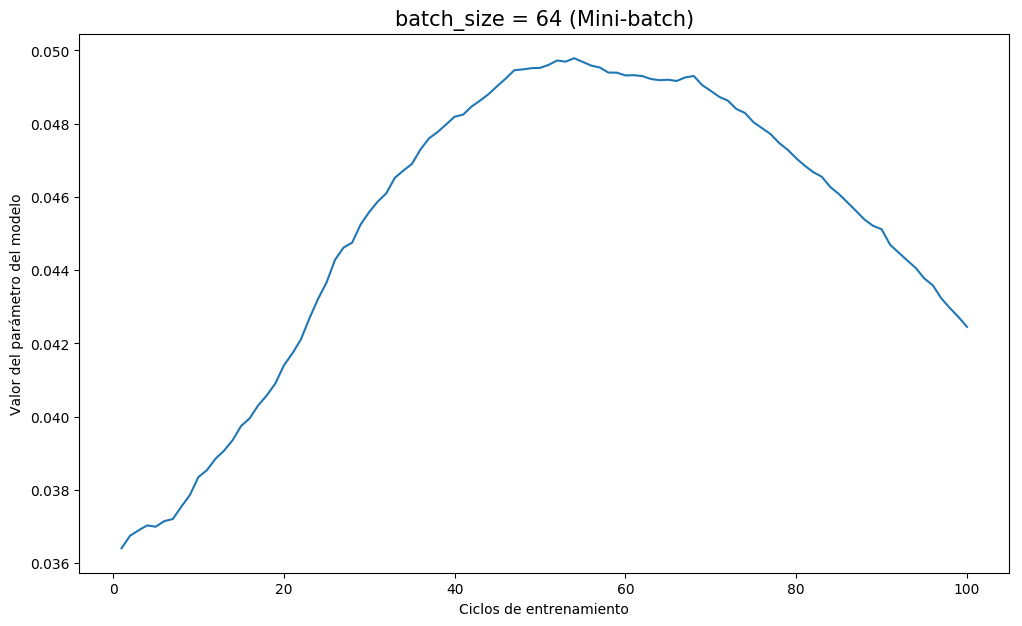

In [13]:
model = Sequential()
model.add(Dense(20, input_dim=20, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd)
weights = []
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[0].get_weights()))

checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=False)
model.fit(X_train, y_train, batch_size=64, 
          epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[print_weights])
w_64 = [item[0] for item in [item[0] for item in [item[0] for item in weights]]]


plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Valor del parámetro del modelo')
plt.title('batch_size = 64 (Mini-batch)', size = 15);
ax.plot(np.linspace(1,100,100),w_64);

Utilizando un batch size de 64 registros vemos una mejor convergencia, la curva comienza a tender rápidamente durante los primeros ciclos hacia los valores cercanos a la convergencia y poco a poco se estanca.

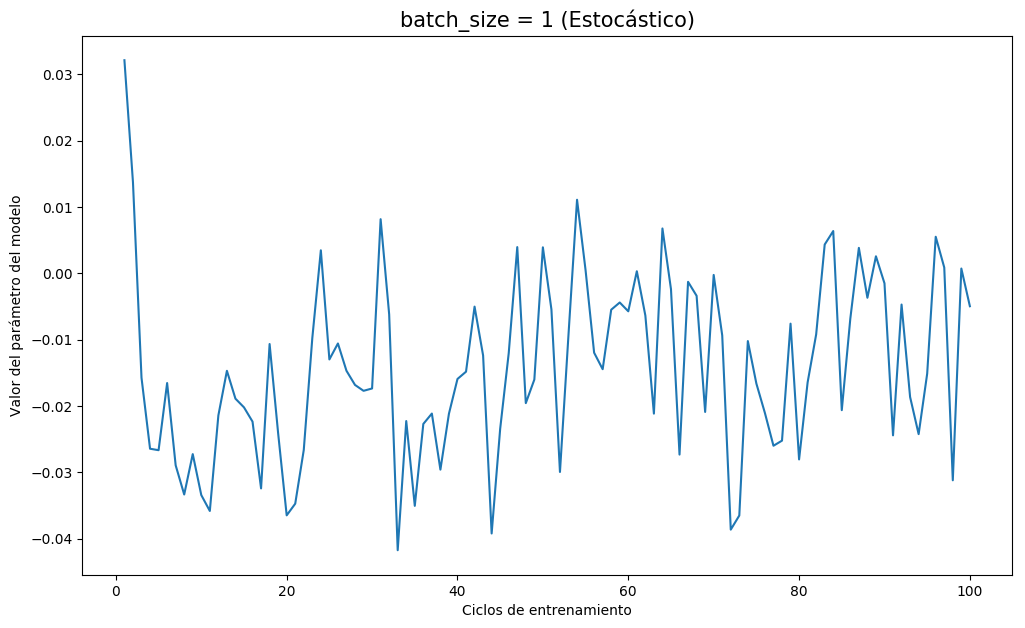

In [14]:
model = Sequential()
model.add(Dense(20, input_dim=20, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd)
weights = []
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[0].get_weights()))

checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=False)
model.fit(X_train, y_train, batch_size=1, 
          epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[print_weights])
w_1 = [item[0] for item in [item[0] for item in [item[0] for item in weights]]]


plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Valor del parámetro del modelo')
plt.title('batch_size = 1 (Estocástico)', size = 15);
ax.plot(np.linspace(1,100,100),w_1);

Podemos ver que la curva de convergencia de un batch size de 1 es bastante más accidentada sin embargo la tendencia general converge.

Otra forma de visualizar el comportamiento de los métodos de gradientes es ver cómo se van actualizando los parámetros. Para ello el código generado con `compare_gd_strategies` toma simulaciones anteriormente realizadas. Se aprecia que el principal comportamiento del método Batch es mantener una tendencia lineal en la actualización de parámetros y __para__ una vez encontrada la optimización de la superficie de respuesta. El método estocástico presenta un comportamiento mucho más errático en cuanto al camino, pero evita el problema de caer en mínimos locales. El comportamiento de Mini Batch se sitúa entre Batch y un método estocástico, dado que calcula las gradientes en pequeñas submuestras de casos. Una de las principales ventajas de Mini Batch por sobre la gradiente estocástica es que está orientada a realizar computaciones más eficientes.

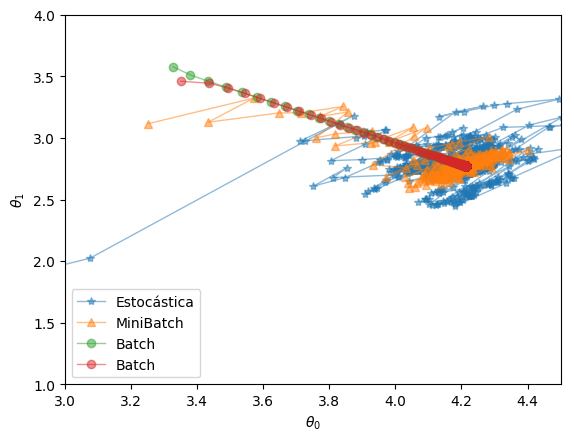

In [16]:
X, y = artificial_points()
batch_gd = batch_gd_plot(X, y, theta=1, alpha=.2, theta_path=True)
stochastic_gd = stochastic_gd_plot(X, y, theta_path=True)
minibatch_gd = mini_batch_gd_plot(X, y, theta=1, alpha=.2, theta_path=True)
compare_gd_strategies(batch_gd, stochastic_gd, minibatch_gd)

#### Digresión: Otros algoritmos de optimización usados actualmente
> #### Momentum
>> Similar a SGD, con la diferencia de que el optimizador lleva la cuenta de una cierta "cantidad de movimiento" hacia la dirección en la que iba, igual que el momento de inercia cuando corremos y tratamos de cambiar de dirección, por lo que las irregularidades puntuales del espacio de búsqueda no afectan tanto al recorrido general del optimizador hacia el mínimo. Momentum disminuye las oscilaciones erráticas de SGD.
>
> #### Momentum de Nesterov (o Gradiente acelerado de Nesterov)
>> Yurii Nesterov se dió cuenta que la aproximación del momentum general era demasiado 'bruta', su analogía era que momentum era como dejar a una pelota caer por una ladera. El problema que plantea Nesterov es que cuando la pelota llegue al mínimo, va a tener demasiado momentum y, por consiguiente, va a tener dificultades parando y quedandose en el mínimo, para evitar esto Nesterov plantea una forma de _'predecir'_ la situación en la posición en la que debiesemos estar en el siguiente paso utilizando momentum, a partir de esto, hace correcciones más apropiadas e inteligentes.
>
> #### Adagrad
>> Dicho de forma simple, adagrad permite al learning rate adaptarse de acuerdo a los parámetros, de esta forma, ciertos parámetros con poca ocurrencia tienen la oportunidad de aportar de mayor forma a la dirección en la que se mueve el optimizador. Utiliza diferentes learning rate para cada parámetro para cada paso temporal, por lo que es bastante flexible y eficaz.
>
> #### AdaDelta
>> Adagrad presenta un problema, el learning rate decae constantemente a lo largo del entrenamiento, lo que hace que para iteraciones de entrenamiento posteriores las actualizaciones a los parámetros son casi inperceptibles. Para no entrar en mayores detalles matemáticos, nos quedaremos con la idea de que AdaDelta soluciona esto, lo que ayuda a entrenar modelos con gran cantidad de parámetros y largos ciclos de entrenamiento.

# Referencias


* Hardt, M. 2018. EE227C: Convex Optimization and Approximation. Course notes. Department of Electrical Engineering and Computer Science, University of California, Berkeley.
* Dabbura, I. 2017. Gradient Descent algorithm and its variants. _Towards DataScience_. https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3 (visitado el 31 de Octubre, 2018)
* Patterson, J; Gibson, A. 2017. Deep Learning: a Practitioner's Approach. Ch1: A Review of Machine Learning. Stochastic Gradient Descent. O'Reilly